In [1]:
pip install deap

     |████████████████████████████████| 153kB 4.9MB/s 


In [2]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

class Classifier_B(nn.Module):
    def __init__(self):
        super(Classifier_B, self).__init__()

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=8, stride = 2, padding = 3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=6, stride = 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels = 128, kernel_size=5, stride = 1)
        self.dropout2 = nn.Dropout(0.5)
        self.FC1 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.dropout1(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout2(x)
        x = x.view(in_size, -1)
        x = self.FC1(x)
        x = self.softmax(x)
        
        return x
    
    def get_output(self, x):
        in_size = x.size(0)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(in_size, -1)
        x = self.FC1(x)
        x = self.softmax(x)

        return x

In [0]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import glob
from torchvision import datasets, transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
from deap import creator, base, tools, algorithms
import os

# Hyper parameters
params = {
	'input_size': 28,  # image size 1x64x64
	'batch_size': 64,  # batch size
	'r': 100,   # population size
	'L': 20,  # number of iterations
	'nc': 1,  # number of channels
	'nz': 100,  # size of z latent vector
	'ngf': 64,  # size of feature maps in generator
	'ndf': 32,  # size of feature maps in discriminator
	'num_epochs': 1000,  # number of epochs
	'lr': 0.0001,  # learning rate
	'beta1': 0.5,   # beta1 for adam optimizer
	'ngpu': 1,  # number of GPU
	'lambda_gp': 10,  # loss weight for gradient penalty
	'n_critic': 5,
}

model_weight_path = './data/weights/netG_12500.pth'
classifier_weight_path = './classifiers/checkpoint'
netG = None
MSE_loss = nn.MSELoss()

# transform
transform = transforms.Compose([transforms.Normalize(mean=(0.5,), std=(0.5,))])

def imshow(img):
	img = (img + 1) / 2
	img = img.squeeze()
	np_img = img.numpy()
	plt.imshow(np_img, cmap='gray')
	plt.show()

def imshow_images(rec_rr, zs, netG):
	fig = plt.figure()
	for i in range(rec_rr):
		img = netG(zs[i]).detach()
		img = (img + 1) / 2
		img = img.squeeze()
		np_img = img.numpy()
		ax = fig.add_subplot(1,rec_rr,i+1)
		ax.imshow(np_img)
	plt.show()

def defensegan(x, observation_change=False, observation_step=100):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	x = x.view(28, 28).numpy().astype(np.float64)
	initial_population = torch.FloatTensor(params['r'], params['nz'], 1, 1).normal_(0, 1)
	initial_population = initial_population.view(params['r'], params['nz']).numpy()
	def evalFunc(individual):
		individual = torch.from_numpy(individual).view(1, params['nz'], 1, 1)
		fitness = np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2) ** 2,
		return fitness
	def initIndividual(icls, content):
		return icls(content)
	def initPopulation(pcls, ind_init):
		return pcls(ind_init(c) for c in initial_population)
	creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
	creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)  # minimizing the fitness value
	toolbox = base.Toolbox()
	IND_SIZE = params['nz']
	POPULATION = params['r']
	CXPB, MUTPB = 0.4, 0.2
	GENERATIONS = params['L']
	toolbox.register("attr_float", random.random)
	toolbox.register("individual", initIndividual, creator.Individual)
	toolbox.register("population", initPopulation, list, toolbox.individual)
	toolbox.register("evaluate", evalFunc)
	toolbox.register("mate", tools.cxUniform, indpb=0.1)
	toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
	toolbox.register("select", tools.selTournament, tournsize=3)

	random.seed(777)

	# pop = toolbox.population(n=POPULATION)
	pop = toolbox.population()

	print("Start of evolution")

	# Evaluate the entire population
	# print(fitnesses) -> [(84,), (105,), (96,), (104,), (94,),  ... ] 이런식으로 저장됨.
	fitnesses = list(map(toolbox.evaluate, pop))
	for ind, fit in zip(pop, fitnesses):
		ind.fitness.values = fit

	# Extracting all the fitnesses of
	fits = [ind.fitness.values[0] for ind in pop]

	# Variable keeping track of the number of generations
	g = 0

	# Begin the evolution
	while min(fits) > 10 and g < GENERATIONS:
		# A new generation
		g = g + 1

		# Select the next generation individuals
		# len(pop) -> 50, len(pop[0]) -> 5
		offspring = toolbox.select(pop, len(pop))

		# Clone the selected individuals
		offspring = list(map(toolbox.clone, offspring))

		# Apply crossover and mutation on the offspring
		'''
        they modify those individuals within the toolbox container 
        and we do not need to reassign their results.
        '''
		# TODO: want p_new1 = p_m - beta(p_m - p_d), p_new2 = p_m + beta(p_m - p_d)
		# want to customize mutation method... there is no proper mutation operator in deap.tools...

		for child1, child2 in zip(offspring[::2], offspring[1::2]):
			if random.random() < CXPB:
				size = min(len(child1), len(child2))
				for i in range(5):
					cxpoint = random.randint(2, size - 1)
					mtpoint = cxpoint - 1
					# cxpoint -1 위치 : mutate
					beta = random.random()
					child1[mtpoint] = child1[mtpoint] - beta * (child1[mtpoint] - child2[mtpoint])
					child2[mtpoint] = child1[mtpoint] + beta * (child1[mtpoint] - child2[mtpoint])

				# crossover : one point crossover (temporary crossover algorithm)
				# child1[cxpoint:], child2[cxpoint:] = child2[cxpoint:], child1[cxpoint:]
				del child1.fitness.values
				del child2.fitness.values

		for child1, child2 in zip(offspring[::2], offspring[1::2]):
			if random.random() < CXPB:
				toolbox.mate(child1, child2)
				del child1.fitness.values
				del child2.fitness.values

		for mutant in offspring:
			if random.random() < MUTPB:
				toolbox.mutate(mutant)
				del mutant.fitness.values

		# Evaluate the individuals with an invalid fitness
		invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
		fitnesses = map(toolbox.evaluate, invalid_ind)
		for ind, fit in zip(invalid_ind, fitnesses):
			ind.fitness.values = fit

		# The population is entirely replaced by the offspring
		pop[:] = offspring

		# Gather all the fitnesses in one list and print the stats
		fits = [ind.fitness.values[0] for ind in pop]

		length = len(pop)
		mean = sum(fits) / length
		sum2 = sum(x * x for x in fits)
		std = abs(sum2 / length - mean ** 2) ** 0.5

		if g % 10 == 0:
			print("-- Generation %i --" % g)
			print("  Min %s" % min(fits))
			print("  Max %s" % max(fits))
			print("  Avg %s" % mean)
			print("  Std %s" % std)
			best_ind = tools.selBest(pop, 1)[0]
			z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
			gen_image = netG(z)
			# imshow(gen_image.detach())

	print("-- End of (successful) evolution --")

	best_ind = tools.selBest(pop, 1)[0]
	z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
	gen_image = netG(z)
	imshow(gen_image.detach())
	return gen_image

def main():
	# Generator(ngpu, nc, nz, ngf)
  global netG
  netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
  netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_12500.pth', map_location=torch.device('cpu')))

	# Classifier
  classifier_b = Classifier_B()
  classifier_b.load_state_dict(torch.load('/gdrive/My Drive/checkpoints/modelB_ckpt.pt')['model'])
  classifier_b.eval()

	# available epsilon values : 0.1, 0.2, 0.3, 0.05, 0.15, 0.25
  epsilon_set = [0.1, 0.2, 0.3, 0.05, 0.15, 0.25]
  acc_defense_gan = [0] * 6  # accuracy of defense GAN
  acc_classifier_b = [0] * 6  # accuracy of classifier b
  total = [0] * 6  # number of fgsm images for each epsilon
  correct_defense_gan = [0] * 6  # number of fgsm images correctly classified for each epsilon by defense gan
  correct_classifier_b = [0] * 6  # number of fgsm images correctly classified for each epsilon by classifier b

  for file_path in glob.glob("/gdrive/My Drive/classifier_b_fgsm_small_sample/*.jpg"):
    #for file_path in glob.glob("./data/fgsm_images_a/*.jpg"):  # fgsm images from classifier a (fgsm_images_a)
		# get epsilon and ground truth by parsing
    #print(file_path[48:])
    print("***********************")
    print("*** start *************")
    print("***********************")
    temp_file_path = file_path[48:]
    file_name = temp_file_path.split('_')
    epsilon = float(file_name[0])
    ground_truth = float(file_name[1])
    fgsm_truth = float(file_name[3])
    print('This fgsm image is originally ' + str(int(ground_truth)) + ', misclassified as ' +
			  str(int(fgsm_truth)) + ' with epsilon ' + str(epsilon))
    fgsm_image = Image.open(file_path)
    fgsm_image = TF.to_tensor(fgsm_image)
    bef_image = fgsm_image
    fgsm_image = transform(fgsm_image)  # torch.Size([1, 28, 28])
    imshow(fgsm_image)
    #break
    # do defense gan
    result_image = defensegan(fgsm_image)  # return type tensor [1, 1, 28, 28]. image G(z) that has minimum fitness
    #print(bef_image)
    #print(fgsm_image)
    #print(result_image)		
		# to classify image
    outputs_defense_gan = classifier_b(result_image)
    outputs_classifier_b = classifier_b(fgsm_image.view(1, 1, params['input_size'], params['input_size']))
    prediction_defense_gan = torch.max(outputs_defense_gan.data, 1)[1]
    prediction_classifier_b = torch.max(outputs_classifier_b.data, 1)[1]
    #print('output from defense gan is ' + str(outputs_defense_gan))
    #print('output from classifier is ' + str(outputs_classifier_b))
    print('defense gan classified fgsm image (' + str(ground_truth) + ' to ' + str(fgsm_truth) +
        ') as ' + str(prediction_defense_gan.item()))
    print('classifier b classified fgsm image (' + str(ground_truth) + ' to ' + str(fgsm_truth) +
        ') as ' + str(prediction_classifier_b.item()))
    epsilon_index = epsilon_set.index(epsilon)  # returns the index of epsilon from epsilon_set
    total[epsilon_index] += 1
    if prediction_defense_gan.item() == ground_truth:
      print('prediction from defense gan correct!')
      correct_defense_gan[epsilon_index] += 1
    if prediction_classifier_b.item() == ground_truth:
      print('prediction from classifier correct! - this should not happen...')
      correct_classifier_b[epsilon_index] += 1
    print('total # images for each epsilon : ' + str(total))
    print('correct defense gan : ' + str(correct_defense_gan))
    print('correct classifier b : ' + str(correct_classifier_b))
    #break

***********************
*** start *************
***********************
This fgsm image is originally 0, misclassified as 3 with epsilon 0.2


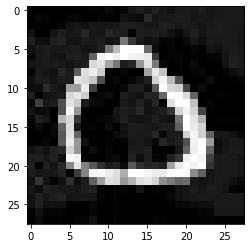

Start of evolution


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


-- Generation 10 --
  Min 29.09302772106122
  Max 61.04641055802072
  Avg 40.87676441018485
  Std 4.40500575910592
-- Generation 20 --
  Min 21.305619702449956
  Max 24.849577089385075
  Avg 22.459341380745347
  Std 0.7385044873087551
-- End of (successful) evolution --


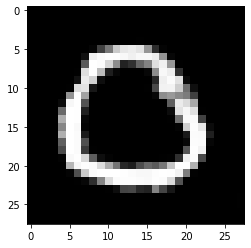

defense gan classified fgsm image (0.0 to 3.0) as 0
classifier b classified fgsm image (0.0 to 3.0) as 3
prediction from defense gan correct!
total # images for each epsilon : [0, 1, 0, 0, 0, 0]
correct defense gan : [0, 1, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 1, misclassified as 6 with epsilon 0.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


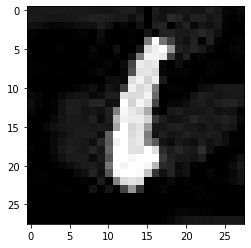

Start of evolution
-- Generation 10 --
  Min 41.58205059315863
  Max 74.72354668937376
  Avg 50.81025559372253
  Std 4.54053725993409
-- Generation 20 --
  Min 34.97322226383401
  Max 65.0705633060705
  Avg 40.06013255008503
  Std 3.834215052644737
-- End of (successful) evolution --


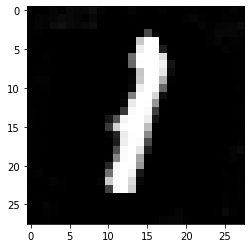

defense gan classified fgsm image (1.0 to 6.0) as 1
classifier b classified fgsm image (1.0 to 6.0) as 6
prediction from defense gan correct!
total # images for each epsilon : [0, 2, 0, 0, 0, 0]
correct defense gan : [0, 2, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 1, misclassified as 2 with epsilon 0.2


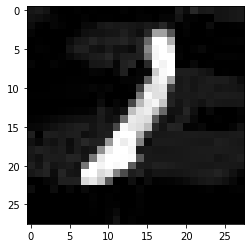

Start of evolution
-- Generation 10 --
  Min 11.847797231761309
  Max 29.12734604990633
  Avg 16.79843117318115
  Std 3.4225965429319496
-- End of (successful) evolution --


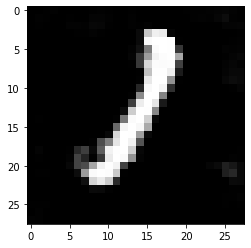

defense gan classified fgsm image (1.0 to 2.0) as 1
classifier b classified fgsm image (1.0 to 2.0) as 2
prediction from defense gan correct!
total # images for each epsilon : [0, 3, 0, 0, 0, 0]
correct defense gan : [0, 3, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 0, misclassified as 5 with epsilon 0.2


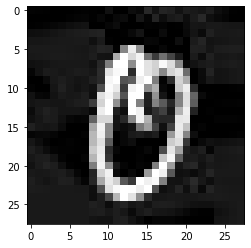

Start of evolution
-- Generation 10 --
  Min 39.65265734452023
  Max 142.67317983433284
  Avg 64.52210198959337
  Std 22.870168327816483
-- Generation 20 --
  Min 33.81767340686383
  Max 69.80881021603017
  Avg 39.59360595021297
  Std 6.9259108911970175
-- End of (successful) evolution --


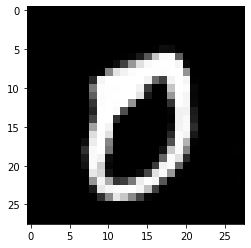

defense gan classified fgsm image (0.0 to 5.0) as 0
classifier b classified fgsm image (0.0 to 5.0) as 5
prediction from defense gan correct!
total # images for each epsilon : [0, 4, 0, 0, 0, 0]
correct defense gan : [0, 4, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 1, misclassified as 6 with epsilon 0.2


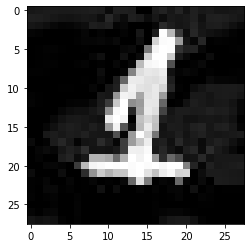

Start of evolution
-- Generation 10 --
  Min 40.87206378463737
  Max 129.88911500514482
  Avg 55.5573747483053
  Std 13.043190925114649
-- Generation 20 --
  Min 36.79362420550089
  Max 43.04504990126988
  Avg 38.3876332376837
  Std 0.9021345130257398
-- End of (successful) evolution --


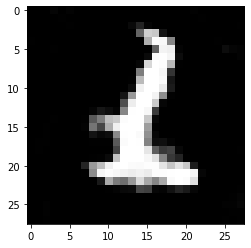

defense gan classified fgsm image (1.0 to 6.0) as 1
classifier b classified fgsm image (1.0 to 6.0) as 6
prediction from defense gan correct!
total # images for each epsilon : [0, 5, 0, 0, 0, 0]
correct defense gan : [0, 5, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 2, misclassified as 8 with epsilon 0.2


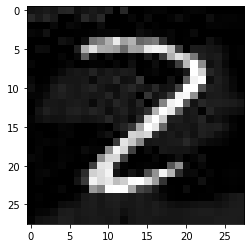

Start of evolution
-- Generation 10 --
  Min 47.30256615533706
  Max 70.3839739494131
  Avg 58.37801194014655
  Std 4.029880420229418
-- Generation 20 --
  Min 30.830987632839115
  Max 60.6128062434215
  Avg 40.02731246373601
  Std 4.471374667043252
-- End of (successful) evolution --


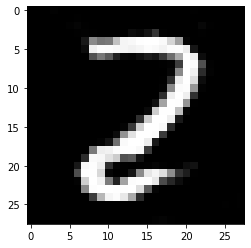

defense gan classified fgsm image (2.0 to 8.0) as 2
classifier b classified fgsm image (2.0 to 8.0) as 8
prediction from defense gan correct!
total # images for each epsilon : [0, 6, 0, 0, 0, 0]
correct defense gan : [0, 6, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 2, misclassified as 0 with epsilon 0.2


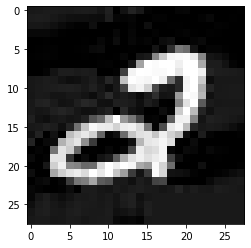

Start of evolution
-- Generation 10 --
  Min 56.235954384882525
  Max 147.036439806213
  Avg 71.76296136683817
  Std 16.593069273147105
-- Generation 20 --
  Min 51.0051891864344
  Max 55.0478399152441
  Avg 52.06203413104484
  Std 0.6253209195990852
-- End of (successful) evolution --


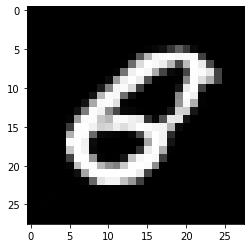

defense gan classified fgsm image (2.0 to 0.0) as 0
classifier b classified fgsm image (2.0 to 0.0) as 0
total # images for each epsilon : [0, 7, 0, 0, 0, 0]
correct defense gan : [0, 6, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 3, misclassified as 5 with epsilon 0.2


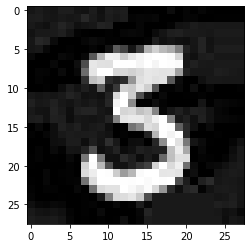

Start of evolution
-- Generation 10 --
  Min 56.065505572744804
  Max 105.80666234597619
  Avg 68.77294045300279
  Std 8.53210301795918
-- Generation 20 --
  Min 40.999172816944046
  Max 59.239060772817496
  Avg 46.806425976298605
  Std 3.0596228950418896
-- End of (successful) evolution --


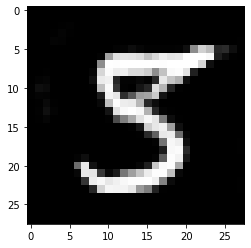

defense gan classified fgsm image (3.0 to 5.0) as 5
classifier b classified fgsm image (3.0 to 5.0) as 5
total # images for each epsilon : [0, 8, 0, 0, 0, 0]
correct defense gan : [0, 6, 0, 0, 0, 0]
correct classifier b : [0, 0, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 3, misclassified as 2 with epsilon 0.2


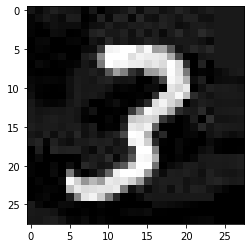

Start of evolution
-- Generation 10 --
  Min 43.924852036613444
  Max 116.64459086159903
  Avg 52.071396784500664
  Std 8.859511785532776
-- Generation 20 --
  Min 36.572167354473166
  Max 64.41483997342058
  Avg 42.5497784359132
  Std 5.091182973551428
-- End of (successful) evolution --


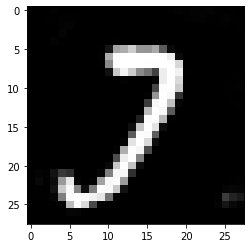

defense gan classified fgsm image (3.0 to 2.0) as 7
classifier b classified fgsm image (3.0 to 2.0) as 3
prediction from classifier correct! - this should not happen...
total # images for each epsilon : [0, 9, 0, 0, 0, 0]
correct defense gan : [0, 6, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 2, misclassified as 7 with epsilon 0.2


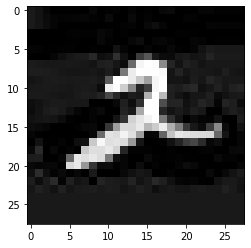

Start of evolution
-- Generation 10 --
  Min 58.61825515358088
  Max 103.94711281747512
  Avg 66.17422799392567
  Std 7.174141998150428
-- Generation 20 --
  Min 48.75902464316747
  Max 61.713580671481814
  Avg 52.37812422955427
  Std 2.0353876731280764
-- End of (successful) evolution --


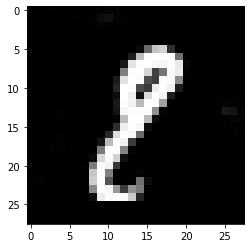

defense gan classified fgsm image (2.0 to 7.0) as 8
classifier b classified fgsm image (2.0 to 7.0) as 7
total # images for each epsilon : [0, 10, 0, 0, 0, 0]
correct defense gan : [0, 6, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 3, misclassified as 8 with epsilon 0.2


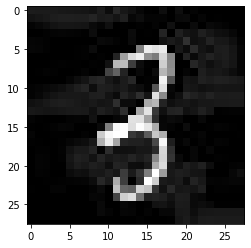

Start of evolution
-- Generation 10 --
  Min 31.64263965080021
  Max 72.54865528284138
  Avg 46.92907338826356
  Std 6.196241483853695
-- Generation 20 --
  Min 25.05385091806808
  Max 32.66648382835617
  Avg 27.003743749612973
  Std 1.2126333566366356
-- End of (successful) evolution --


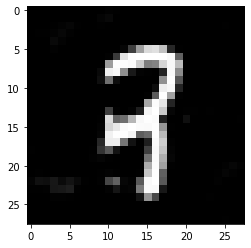

defense gan classified fgsm image (3.0 to 8.0) as 3
classifier b classified fgsm image (3.0 to 8.0) as 8
prediction from defense gan correct!
total # images for each epsilon : [0, 11, 0, 0, 0, 0]
correct defense gan : [0, 7, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 6, misclassified as 2 with epsilon 0.2


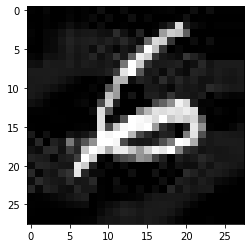

Start of evolution
-- Generation 10 --
  Min 39.80497886694144
  Max 89.14577447320582
  Avg 50.363235254543525
  Std 11.77367509504236
-- Generation 20 --
  Min 38.93625242556599
  Max 42.31245727545721
  Avg 39.71361180668895
  Std 0.44939182045602016
-- End of (successful) evolution --


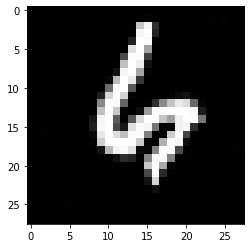

defense gan classified fgsm image (6.0 to 2.0) as 6
classifier b classified fgsm image (6.0 to 2.0) as 2
prediction from defense gan correct!
total # images for each epsilon : [0, 12, 0, 0, 0, 0]
correct defense gan : [0, 8, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 5, misclassified as 7 with epsilon 0.2


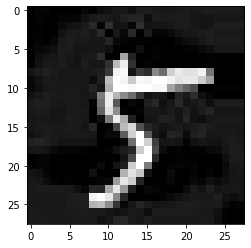

Start of evolution
-- Generation 10 --
  Min 43.36774650755592
  Max 54.666326326117584
  Avg 47.6290294829099
  Std 2.1078498765630704
-- Generation 20 --
  Min 41.63515877744897
  Max 49.11766339610901
  Avg 43.1424460373353
  Std 1.0511182755225794
-- End of (successful) evolution --


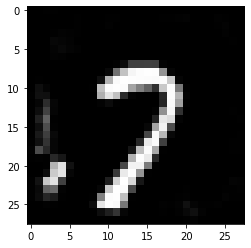

defense gan classified fgsm image (5.0 to 7.0) as 7
classifier b classified fgsm image (5.0 to 7.0) as 7
total # images for each epsilon : [0, 13, 0, 0, 0, 0]
correct defense gan : [0, 8, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 4, misclassified as 9 with epsilon 0.2


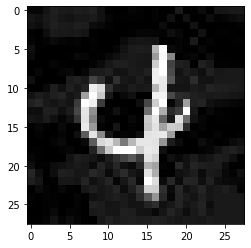

Start of evolution
-- Generation 10 --
  Min 43.94230383414012
  Max 125.58726599627343
  Avg 63.51518979907393
  Std 17.05020643191245
-- Generation 20 --
  Min 21.30316512135407
  Max 43.34265396621502
  Avg 28.090940590233622
  Std 4.558742723589382
-- End of (successful) evolution --


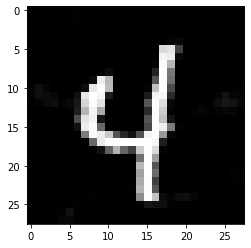

defense gan classified fgsm image (4.0 to 9.0) as 4
classifier b classified fgsm image (4.0 to 9.0) as 9
prediction from defense gan correct!
total # images for each epsilon : [0, 14, 0, 0, 0, 0]
correct defense gan : [0, 9, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 4, misclassified as 6 with epsilon 0.2


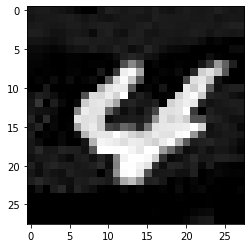

Start of evolution
-- Generation 10 --
  Min 39.12849930119916
  Max 101.4463342156531
  Avg 53.24099393684004
  Std 11.000393659694858
-- Generation 20 --
  Min 21.85572648544823
  Max 38.38040068216485
  Avg 26.38382765488576
  Std 2.797775866563749
-- End of (successful) evolution --


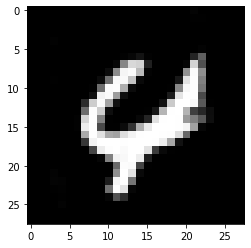

defense gan classified fgsm image (4.0 to 6.0) as 4
classifier b classified fgsm image (4.0 to 6.0) as 6
prediction from defense gan correct!
total # images for each epsilon : [0, 15, 0, 0, 0, 0]
correct defense gan : [0, 10, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 4, misclassified as 1 with epsilon 0.2


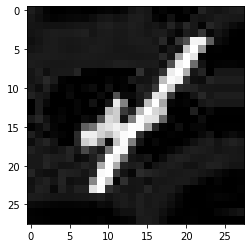

Start of evolution
-- Generation 10 --
  Min 27.797921015453035
  Max 91.26847056935827
  Avg 40.91743295969933
  Std 10.755379105338815
-- Generation 20 --
  Min 14.489758983711981
  Max 64.41346597019805
  Avg 22.446789544446883
  Std 7.17823519558618
-- End of (successful) evolution --


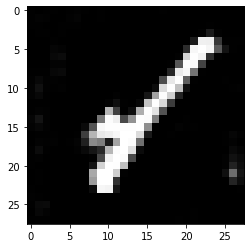

defense gan classified fgsm image (4.0 to 1.0) as 1
classifier b classified fgsm image (4.0 to 1.0) as 1
total # images for each epsilon : [0, 16, 0, 0, 0, 0]
correct defense gan : [0, 10, 0, 0, 0, 0]
correct classifier b : [0, 1, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 5, misclassified as 3 with epsilon 0.2


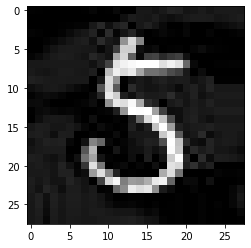

Start of evolution
-- Generation 10 --
  Min 28.46507073485938
  Max 79.18486340244218
  Avg 44.870868758293845
  Std 8.984946994570274
-- Generation 20 --
  Min 17.361964111270836
  Max 37.169559521598735
  Avg 20.422828043674304
  Std 2.4942684056377447
-- End of (successful) evolution --


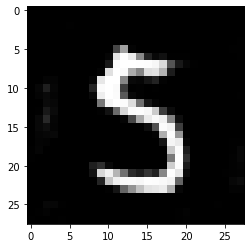

defense gan classified fgsm image (5.0 to 3.0) as 5
classifier b classified fgsm image (5.0 to 3.0) as 5
prediction from defense gan correct!
prediction from classifier correct! - this should not happen...
total # images for each epsilon : [0, 17, 0, 0, 0, 0]
correct defense gan : [0, 11, 0, 0, 0, 0]
correct classifier b : [0, 2, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 6, misclassified as 8 with epsilon 0.2


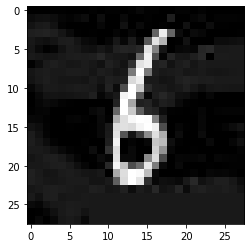

Start of evolution
-- Generation 10 --
  Min 24.473591700341842
  Max 84.30274183374371
  Avg 54.74350313393026
  Std 9.088831039450808
-- Generation 20 --
  Min 23.031407836083343
  Max 61.63009358991136
  Avg 27.641094013286633
  Std 5.583543281491183
-- End of (successful) evolution --


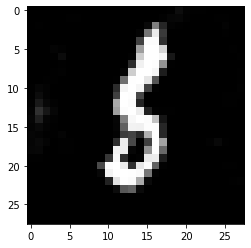

defense gan classified fgsm image (6.0 to 8.0) as 1
classifier b classified fgsm image (6.0 to 8.0) as 8
total # images for each epsilon : [0, 18, 0, 0, 0, 0]
correct defense gan : [0, 11, 0, 0, 0, 0]
correct classifier b : [0, 2, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 6, misclassified as 4 with epsilon 0.2


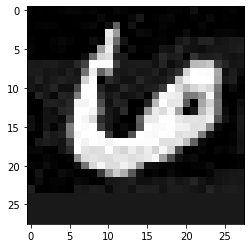

Start of evolution
-- Generation 10 --
  Min 68.5968450218128
  Max 156.17543600297415
  Avg 74.05357916447365
  Std 10.744706825851491
-- Generation 20 --
  Min 63.646649898046626
  Max 76.12413862479386
  Avg 66.13613222863886
  Std 1.5331497710266617
-- End of (successful) evolution --


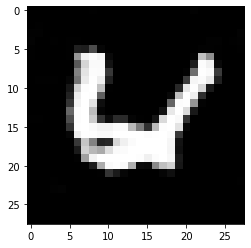

defense gan classified fgsm image (6.0 to 4.0) as 4
classifier b classified fgsm image (6.0 to 4.0) as 4
total # images for each epsilon : [0, 19, 0, 0, 0, 0]
correct defense gan : [0, 11, 0, 0, 0, 0]
correct classifier b : [0, 2, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 5, misclassified as 6 with epsilon 0.2


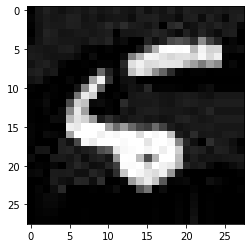

Start of evolution
-- Generation 10 --
  Min 74.70723014524621
  Max 154.07101508718287
  Avg 95.96543162306452
  Std 17.430636815414516
-- Generation 20 --
  Min 60.068529239058705
  Max 89.96569920235558
  Avg 65.79335962568865
  Std 5.980473533836786
-- End of (successful) evolution --


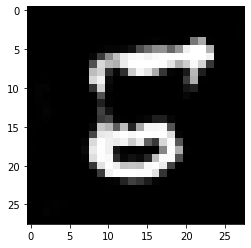

defense gan classified fgsm image (5.0 to 6.0) as 2
classifier b classified fgsm image (5.0 to 6.0) as 6
total # images for each epsilon : [0, 20, 0, 0, 0, 0]
correct defense gan : [0, 11, 0, 0, 0, 0]
correct classifier b : [0, 2, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 7, misclassified as 2 with epsilon 0.2


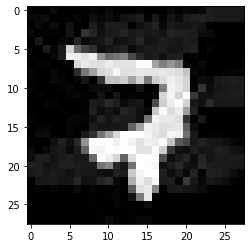

Start of evolution
-- Generation 10 --
  Min 30.911333937051477
  Max 188.57654316797732
  Avg 79.73441518178018
  Std 26.581527784526013
-- Generation 20 --
  Min 28.899015976894116
  Max 83.8269550986319
  Avg 30.70886581937902
  Std 5.603701808352284
-- End of (successful) evolution --


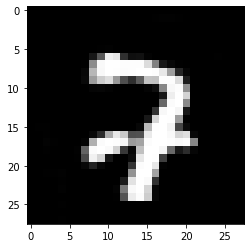

defense gan classified fgsm image (7.0 to 2.0) as 7
classifier b classified fgsm image (7.0 to 2.0) as 2
prediction from defense gan correct!
total # images for each epsilon : [0, 21, 0, 0, 0, 0]
correct defense gan : [0, 12, 0, 0, 0, 0]
correct classifier b : [0, 2, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 8, misclassified as 9 with epsilon 0.2


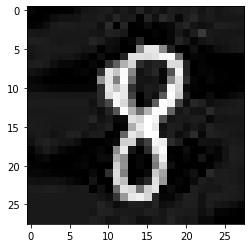

Start of evolution
-- Generation 10 --
  Min 40.77469857063897
  Max 88.28810544251063
  Avg 55.54145700889038
  Std 7.19351994976411
-- Generation 20 --
  Min 30.027638690070084
  Max 58.39799921851646
  Avg 34.31359299975099
  Std 4.310626483656157
-- End of (successful) evolution --


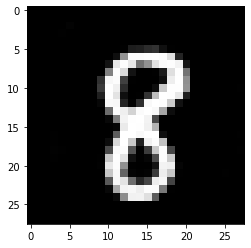

defense gan classified fgsm image (8.0 to 9.0) as 8
classifier b classified fgsm image (8.0 to 9.0) as 8
prediction from defense gan correct!
prediction from classifier correct! - this should not happen...
total # images for each epsilon : [0, 22, 0, 0, 0, 0]
correct defense gan : [0, 13, 0, 0, 0, 0]
correct classifier b : [0, 3, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 9, misclassified as 7 with epsilon 0.2


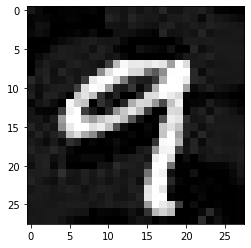

Start of evolution
-- Generation 10 --
  Min 30.99381865786292
  Max 77.1381811162029
  Avg 37.43616987809557
  Std 6.319558258451018
-- Generation 20 --
  Min 29.049805336401466
  Max 33.158390283652
  Avg 30.01709289037893
  Std 0.6280748319888874
-- End of (successful) evolution --


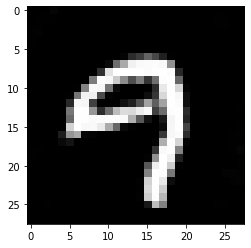

defense gan classified fgsm image (9.0 to 7.0) as 9
classifier b classified fgsm image (9.0 to 7.0) as 7
prediction from defense gan correct!
total # images for each epsilon : [0, 23, 0, 0, 0, 0]
correct defense gan : [0, 14, 0, 0, 0, 0]
correct classifier b : [0, 3, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 9, misclassified as 4 with epsilon 0.2


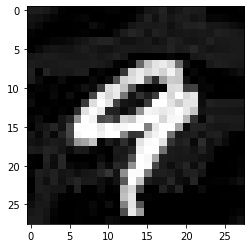

Start of evolution
-- Generation 10 --
  Min 24.847396310584756
  Max 108.52678113946631
  Avg 37.890479117590445
  Std 12.624299197569991
-- Generation 20 --
  Min 20.009383697989623
  Max 22.41852193856339
  Avg 20.977123337498753
  Std 0.5250948352046372
-- End of (successful) evolution --


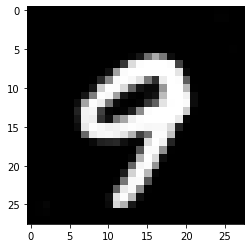

defense gan classified fgsm image (9.0 to 4.0) as 9
classifier b classified fgsm image (9.0 to 4.0) as 4
prediction from defense gan correct!
total # images for each epsilon : [0, 24, 0, 0, 0, 0]
correct defense gan : [0, 15, 0, 0, 0, 0]
correct classifier b : [0, 3, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 8, misclassified as 2 with epsilon 0.2


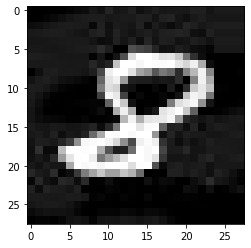

Start of evolution
-- Generation 10 --
  Min 48.81615642643142
  Max 89.27280374239282
  Avg 53.903784379968265
  Std 6.027884460706876
-- Generation 20 --
  Min 40.968069724794404
  Max 46.9471438884101
  Avg 42.35962708215587
  Std 0.8563495527247251
-- End of (successful) evolution --


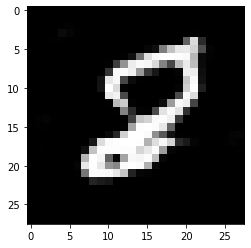

defense gan classified fgsm image (8.0 to 2.0) as 2
classifier b classified fgsm image (8.0 to 2.0) as 2
total # images for each epsilon : [0, 25, 0, 0, 0, 0]
correct defense gan : [0, 15, 0, 0, 0, 0]
correct classifier b : [0, 3, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 8, misclassified as 4 with epsilon 0.2


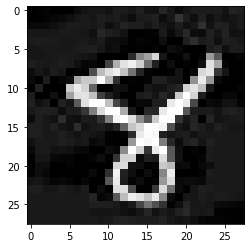

Start of evolution
-- Generation 10 --
  Min 57.34773323820711
  Max 122.47475700012131
  Avg 75.44384357476665
  Std 11.383420571840288
-- Generation 20 --
  Min 52.754610860343526
  Max 57.69074182160208
  Avg 55.258866811370964
  Std 0.9141284105764452
-- End of (successful) evolution --


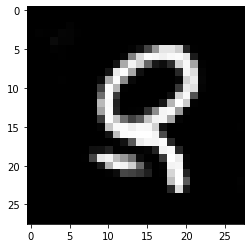

defense gan classified fgsm image (8.0 to 4.0) as 8
classifier b classified fgsm image (8.0 to 4.0) as 4
prediction from defense gan correct!
total # images for each epsilon : [0, 26, 0, 0, 0, 0]
correct defense gan : [0, 16, 0, 0, 0, 0]
correct classifier b : [0, 3, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 9, misclassified as 3 with epsilon 0.2


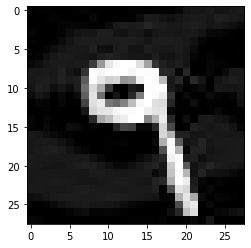

Start of evolution
-- Generation 10 --
  Min 29.30273102905447
  Max 46.10107869451557
  Avg 34.56324009921396
  Std 2.94716035695405
-- Generation 20 --
  Min 23.340329093583165
  Max 28.394254810452576
  Avg 25.802854173525276
  Std 0.6870286273162888
-- End of (successful) evolution --


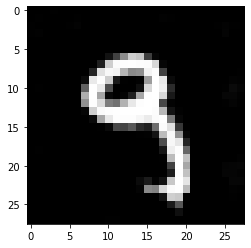

defense gan classified fgsm image (9.0 to 3.0) as 9
classifier b classified fgsm image (9.0 to 3.0) as 3
prediction from defense gan correct!
total # images for each epsilon : [0, 27, 0, 0, 0, 0]
correct defense gan : [0, 17, 0, 0, 0, 0]
correct classifier b : [0, 3, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 7, misclassified as 3 with epsilon 0.2


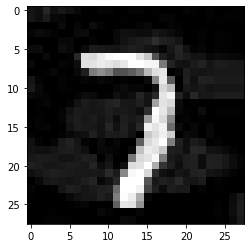

Start of evolution
-- Generation 10 --
  Min 28.52394420175657
  Max 74.40967218386157
  Avg 36.3583177194693
  Std 6.9506180368619095
-- Generation 20 --
  Min 16.122860264837662
  Max 78.83901266709074
  Avg 23.675527434291812
  Std 10.00390415471922
-- End of (successful) evolution --


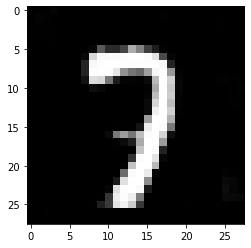

defense gan classified fgsm image (7.0 to 3.0) as 7
classifier b classified fgsm image (7.0 to 3.0) as 7
prediction from defense gan correct!
prediction from classifier correct! - this should not happen...
total # images for each epsilon : [0, 28, 0, 0, 0, 0]
correct defense gan : [0, 18, 0, 0, 0, 0]
correct classifier b : [0, 4, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 7, misclassified as 9 with epsilon 0.2


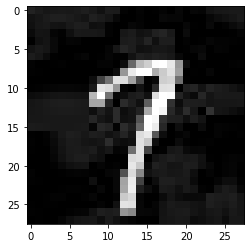

Start of evolution
-- Generation 10 --
  Min 19.980667609636672
  Max 45.91511027830281
  Avg 28.80247614861918
  Std 3.626243459010126
-- Generation 20 --
  Min 17.141018074824142
  Max 18.95588379125688
  Avg 17.924336240209403
  Std 0.35487803676386775
-- End of (successful) evolution --


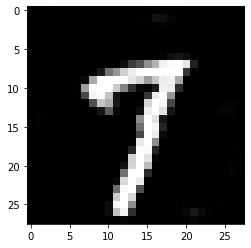

defense gan classified fgsm image (7.0 to 9.0) as 7
classifier b classified fgsm image (7.0 to 9.0) as 9
prediction from defense gan correct!
total # images for each epsilon : [0, 29, 0, 0, 0, 0]
correct defense gan : [0, 19, 0, 0, 0, 0]
correct classifier b : [0, 4, 0, 0, 0, 0]
***********************
*** start *************
***********************
This fgsm image is originally 0, misclassified as 2 with epsilon 0.2


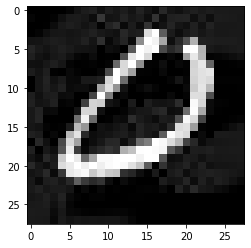

Start of evolution
-- Generation 10 --
  Min 41.40250089777415
  Max 51.81152295840841
  Avg 43.78174014872534
  Std 1.7189840230283262
-- Generation 20 --
  Min 33.55381372345685
  Max 43.767721156230046
  Avg 37.49666213989446
  Std 1.4672987586122277
-- End of (successful) evolution --


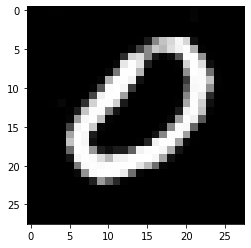

defense gan classified fgsm image (0.0 to 2.0) as 0
classifier b classified fgsm image (0.0 to 2.0) as 2
prediction from defense gan correct!
total # images for each epsilon : [0, 30, 0, 0, 0, 0]
correct defense gan : [0, 20, 0, 0, 0, 0]
correct classifier b : [0, 4, 0, 0, 0, 0]


In [66]:
main()